# Reddit Sentiment Analysis - Baseline Model (Random Forest)

This notebook implements a baseline Random Forest model for sentiment analysis
on Reddit comments using Bag of Words (BoW) feature extraction.

## Table of Contents
1. Setup and Dependencies
2. Data Loading and Preprocessing  
3. Feature Engineering
4. Model Training and Evaluation
5. MLflow Experiment Tracking
6. Results Analysis and Visualization

## 1. Setup and Dependencies

In [ ]:
# Install required packages
!pip install mlflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter

# Machine Learning imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_recall_fscore_support, roc_auc_score, f1_score)

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# NLP imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## 2. Utility Functions for Visualization and Analysis

In [6]:
def setup_mlflow_local():
    """Setup MLflow for local tracking."""
    try:
        # Set local tracking URI
        mlflow.set_tracking_uri("file:./mlruns")
        print("✓ MLflow tracking URI set to local directory: './mlruns'")

        # Test MLflow connection
        with mlflow.start_run():
            mlflow.log_param("test_param", "connection_test")
            mlflow.log_metric("test_metric", 1.0)
        print("✓ MLflow connection test successful")

    except Exception as e:
        print(f"❌ MLflow setup failed: {e}")
        return False
    return True

def preprocess_comment(comment):
    """
    Comprehensive text preprocessing function.

    Args:
        comment (str): Raw comment text

    Returns:
        str: Preprocessed comment text
    """
    if pd.isna(comment):
        return ""

    # Convert to lowercase
    comment = str(comment).lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except important punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet', 'very', 'really'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

def plot_confusion_matrix(confusion_matrix_data, class_names, title="Confusion Matrix", figsize=(8, 6)):
    """Create an enhanced confusion matrix plot."""
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(confusion_matrix_data,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    return plt

def plot_classification_metrics(classification_report_dict, title="Classification Metrics", figsize=(10, 6)):
    """Create a bar plot for classification metrics."""
    # Extract metrics for each class (excluding averages)
    classes = [key for key in classification_report_dict.keys()
              if key not in ['accuracy', 'macro avg', 'weighted avg']]

    metrics = ['precision', 'recall', 'f1-score']
    class_labels = {'-1': 'Negative', '0': 'Neutral', '1': 'Positive'}

    # Prepare data for plotting
    data_for_plot = []
    for class_name in classes:
        class_label = class_labels.get(str(class_name), f'Class {class_name}')
        for metric in metrics:
            if metric in classification_report_dict[class_name]:
                data_for_plot.append({
                    'Class': class_label,
                    'Metric': metric.title(),
                    'Score': classification_report_dict[class_name][metric]
                })

    # Create DataFrame and plot
    metrics_df = pd.DataFrame(data_for_plot)

    plt.figure(figsize=figsize)
    sns.barplot(data=metrics_df, x='Class', y='Score', hue='Metric')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment Class', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt

def plot_feature_importance(model, feature_names, top_n=20, figsize=(10, 8)):
    """Plot top N feature importances."""
    # Get feature importances
    importances = model.feature_importances_

    # Create DataFrame for easier handling
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Select top N features
    top_features = feature_importance_df.head(top_n)

    plt.figure(figsize=figsize)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()

    return plt

def evaluate_model_comprehensive(model, X_test, y_test, class_names):
    """Perform comprehensive model evaluation."""
    # Make predictions
    y_predictions = model.predict(X_test)
    y_prediction_probabilities = model.predict_proba(X_test)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_predictions)
    f1_macro = f1_score(y_test, y_predictions, average='macro')
    f1_weighted = f1_score(y_test, y_predictions, average='weighted')

    # Classification report
    classification_rep = classification_report(y_test, y_predictions, output_dict=True)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predictions)

    print("="*50)
    print("MODEL EVALUATION RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_predictions, target_names=class_names))

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'classification_report': classification_rep,
        'confusion_matrix': conf_matrix,
        'predictions': y_predictions,
        'prediction_probabilities': y_prediction_probabilities
    }

## 3. Data Loading and Preprocessing

In [7]:
# Load dataset
print("\n🔄 Loading Reddit sentiment dataset...")
reddit_df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')

print(f"✓ Dataset loaded successfully!")
print(f"Dataset shape: {reddit_df.shape}")
print(f"Columns: {list(reddit_df.columns)}")

# Initial data exploration
print("\n=== Dataset Overview ===")
print(reddit_df.head())

print("\n=== Class Distribution ===")
sentiment_distribution = reddit_df['category'].value_counts().sort_index()
class_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

for category, count in sentiment_distribution.items():
    label = class_labels[category]
    percentage = (count / len(reddit_df)) * 100
    print(f"{label}: {count} ({percentage:.2f}%)")


🔄 Loading Reddit sentiment dataset...
✓ Dataset loaded successfully!
Dataset shape: (37249, 2)
Columns: ['clean_comment', 'category']

=== Dataset Overview ===
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1

=== Class Distribution ===
Negative: 8277 (22.22%)
Neutral: 13142 (35.28%)
Positive: 15830 (42.50%)


In [8]:
# Data cleaning
print("\n🧹 Performing data cleaning...")
initial_size = len(reddit_df)

# Remove missing values
reddit_df.dropna(inplace=True)
print(f"✓ Removed {initial_size - len(reddit_df)} rows with missing values")

# Remove duplicates
duplicate_count = reddit_df.duplicated().sum()
reddit_df.drop_duplicates(inplace=True)
print(f"✓ Removed {duplicate_count} duplicate rows")

# Remove empty comments
empty_comments = reddit_df['clean_comment'].str.strip() == ''
reddit_df = reddit_df[~empty_comments]
print(f"✓ Removed {empty_comments.sum()} empty comments")

print(f"✓ Final dataset size: {len(reddit_df)} rows")


🧹 Performing data cleaning...
✓ Removed 100 rows with missing values
✓ Removed 350 duplicate rows
✓ Removed 6 empty comments
✓ Final dataset size: 36793 rows


In [9]:
# Download required NLTK data
print("\nDownloading required NLTK data...")
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    print("✓ NLTK data already available")
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    print("✓ NLTK data downloaded successfully")


✓ NLTK data downloaded successfully


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
# Apply preprocessing
print("\nApplying text preprocessing...")
reddit_df['processed_comment'] = reddit_df['clean_comment'].apply(preprocess_comment)

# Remove empty processed comments
empty_processed = reddit_df['processed_comment'].str.strip() == ''
reddit_df = reddit_df[~empty_processed]
print(f"✓ Removed {empty_processed.sum()} comments that became empty after preprocessing")

print(f"✓ Final processed dataset size: {len(reddit_df)} rows")

# Display preprocessing examples
print("\n=== Preprocessing Examples ===")
sample_comments = reddit_df.sample(3)
for idx, row in sample_comments.iterrows():
    print(f"\nOriginal: {row['clean_comment'][:100]}...")
    print(f"Processed: {row['processed_comment'][:100]}...")
    print(f"Sentiment: {class_labels[row['category']]}")


Applying text preprocessing...
✓ Removed 131 comments that became empty after preprocessing
✓ Final processed dataset size: 36662 rows

=== Preprocessing Examples ===

Original: the video egpa oskgog ...
Processed: video egpa oskgog...
Sentiment: Neutral

Original: was looking for chief keef and happily see dope ...
Processed: looking chief keef happily see dope...
Sentiment: Positive

Original: asking the restaurant for your food after paying trend now...
Processed: asking restaurant food paying trend...
Sentiment: Neutral


## 4. Feature Engineering

In [11]:
# Prepare features and target
print("\nCreating Bag of Words features...")

# Initialize vectorizer
bow_max_features = 10000
bow_vectorizer = CountVectorizer(
    max_features=bow_max_features,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=5,  # Ignore terms that appear in fewer than 5 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Create feature matrix
feature_matrix = bow_vectorizer.fit_transform(reddit_df['processed_comment'])
feature_names = bow_vectorizer.get_feature_names_out()

print(f"✓ Feature matrix created!")
print(f"Shape: {feature_matrix.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Feature matrix density: {feature_matrix.nnz / (feature_matrix.shape[0] * feature_matrix.shape[1]):.4f}")


Creating Bag of Words features...
✓ Feature matrix created!
Shape: (36662, 10000)
Number of features: 10000
Feature matrix density: 0.0016


In [12]:
# Prepare target variable
target_variable = reddit_df['category']
class_names = ['Negative', 'Neutral', 'Positive']

print(f"Target variable shape: {target_variable.shape}")
print(f"Class distribution in target:")
for category, count in target_variable.value_counts().sort_index().items():
    print(f"  {class_labels[category]}: {count}")

Target variable shape: (36662,)
Class distribution in target:
  Negative: 8248
  Neutral: 12644
  Positive: 15770


## 5. Model Training and Evaluation

In [14]:
# Split the data
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix,
    target_variable,
    test_size=0.2,
    random_state=42,
    stratify=target_variable
)
print(f"✓ Data split completed!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Splitting data into train and test sets...
✓ Data split completed!
Training set size: 29329 samples
Test set size: 7333 samples


In [15]:
# Train baseline model

# Model parameters
rf_n_estimators = 200
rf_max_depth = 15
rf_random_state = 42

# Initialize model
baseline_model = RandomForestClassifier(
    n_estimators=rf_n_estimators,
    max_depth=rf_max_depth,
    random_state=rf_random_state,
    n_jobs=-1  # Use all available cores
)

In [16]:
# Train model
baseline_model.fit(X_train, y_train)
print(f"✓ Model training completed!")

# Evaluate model
print("\n📊 Evaluating model performance...")
evaluation_results = evaluate_model_comprehensive(
    baseline_model, X_test, y_test, class_names
)

✓ Model training completed!

📊 Evaluating model performance...
MODEL EVALUATION RESULTS
Overall Accuracy: 0.6458
F1-Score (Macro): 0.4894
F1-Score (Weighted): 0.5662

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01      1650
     Neutral       0.68      0.80      0.74      2529
    Positive       0.62      0.85      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.77      0.55      0.49      7333
weighted avg       0.73      0.65      0.57      7333



## 6. MLflow Experiment Tracking

✓ MLflow tracking URI set to local directory: './mlruns'


2025/07/30 17:40:49 INFO mlflow.tracking.fluent: Experiment with name 'Reddit_Sentiment_Baseline' does not exist. Creating a new experiment.


✓ MLflow connection test successful
✓ MLflow experiment set: Reddit_Sentiment_Baseline

Logging experiment to MLflow...
Creating and saving visualizations...


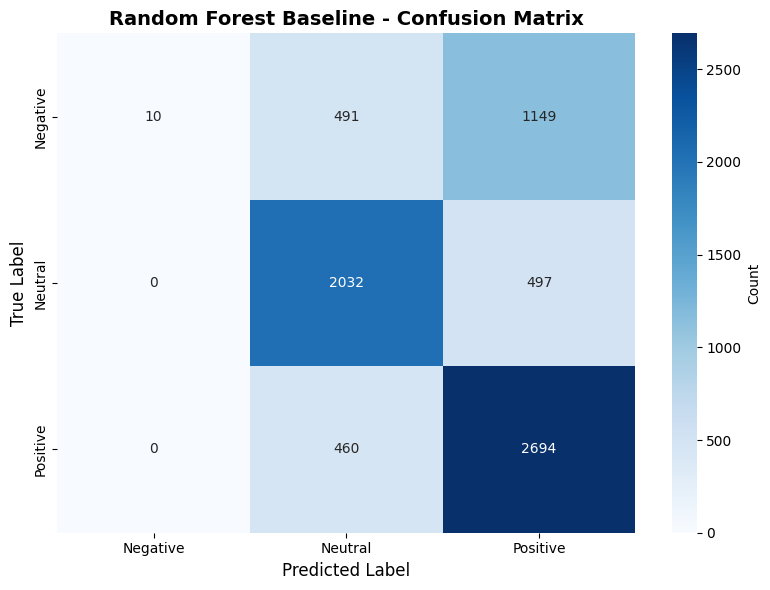

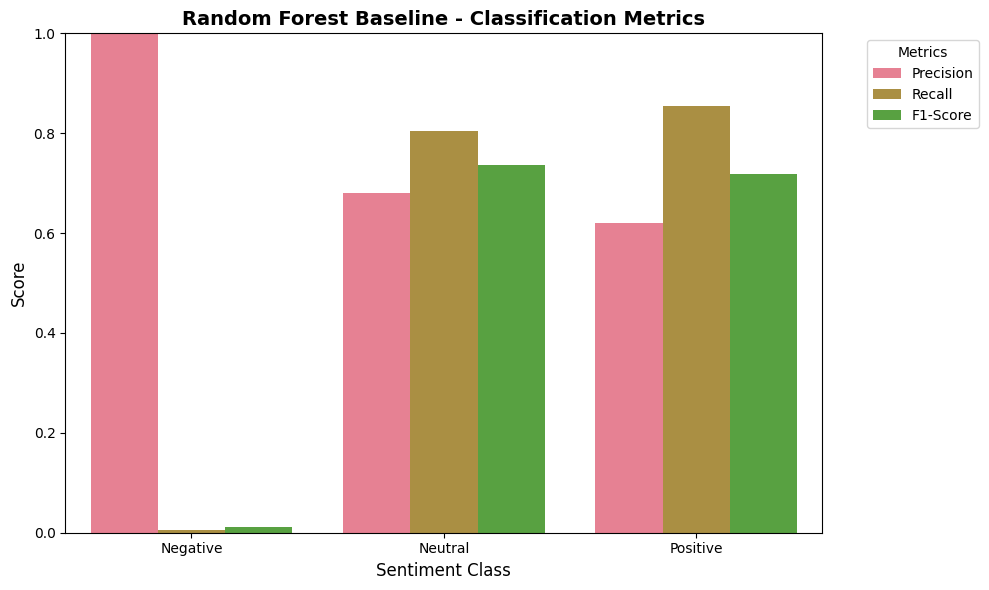

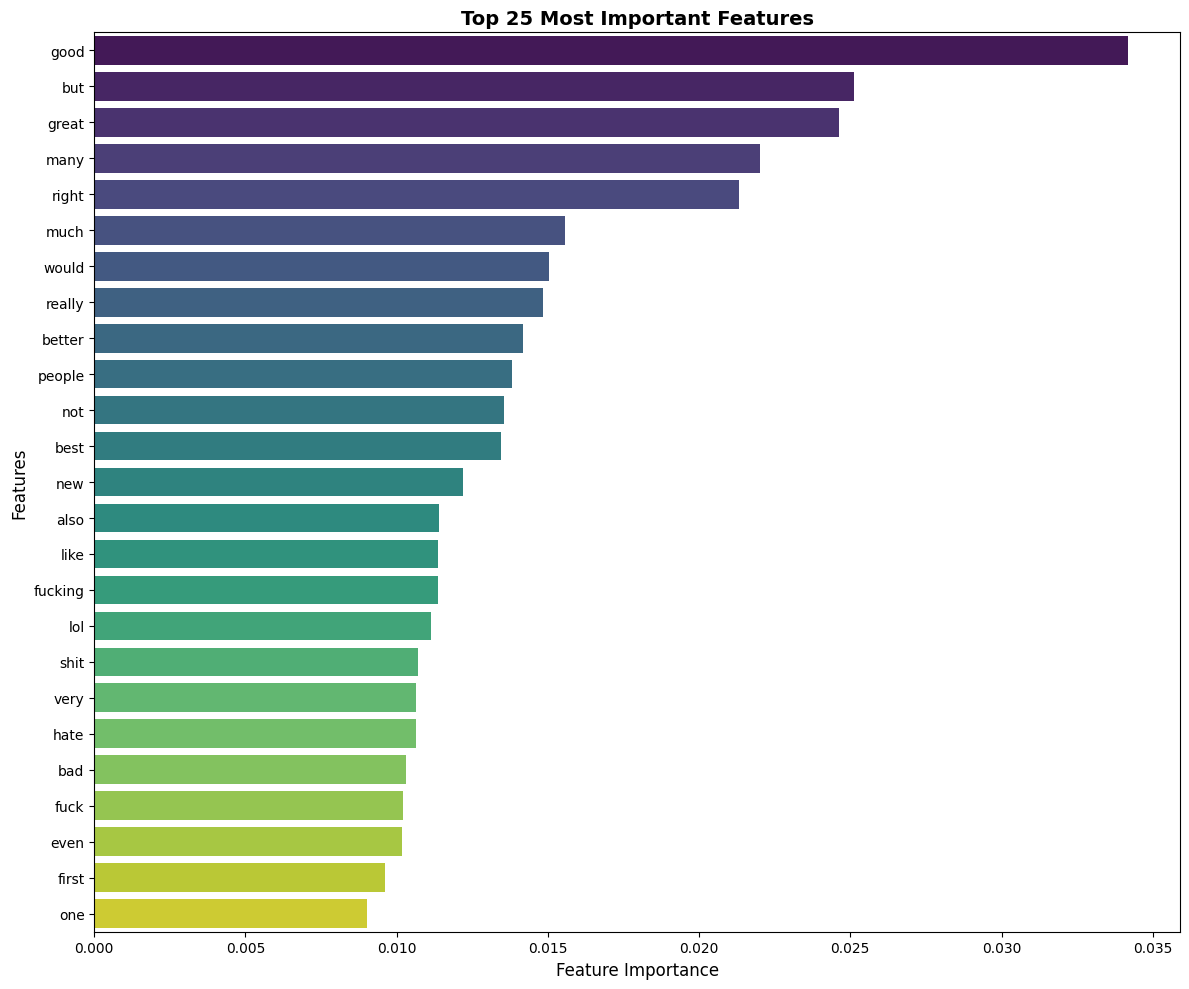

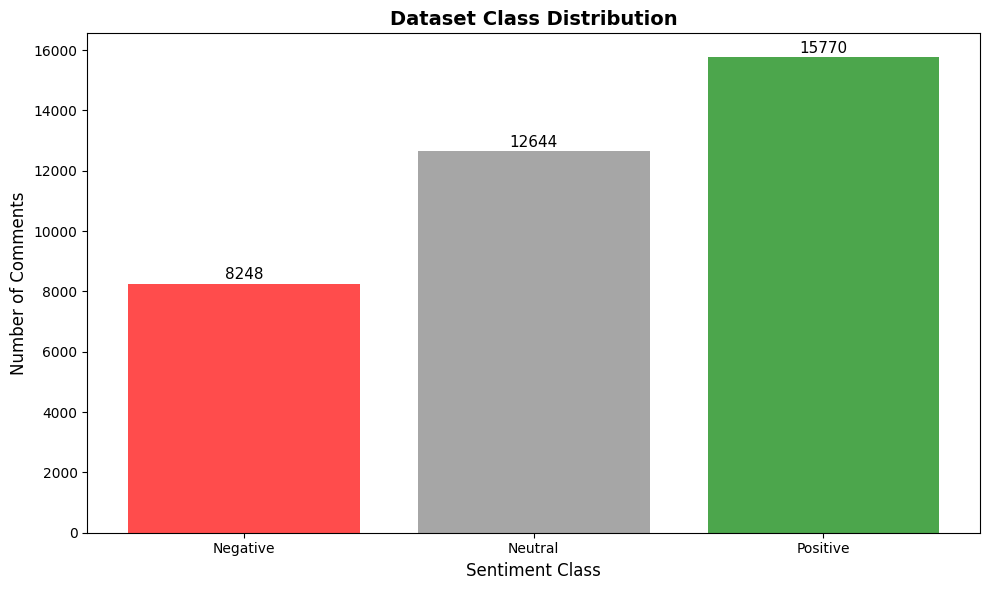

2025/07/30 17:40:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/30 17:40:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ All artifacts logged to MLflow successfully!

📋 MLflow Run Information:
Run ID: d5e81300a39947fdaa833a205f4f0276
Experiment ID: 834032177039045850
Tracking URI: file:./mlruns


In [17]:
mlflow_setup_success = setup_mlflow_local()

if mlflow_setup_success:
    # Set experiment
    experiment_name = "Reddit_Sentiment_Baseline"
    mlflow.set_experiment(experiment_name)

    print(f"✓ MLflow experiment set: {experiment_name}")

    # Start MLflow run
    print("\nLogging experiment to MLflow...")

    with mlflow.start_run() as run:
        # Set run metadata
        mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_Enhanced")
        mlflow.set_tag("experiment_type", "baseline")
        mlflow.set_tag("model_type", "RandomForestClassifier")
        mlflow.set_tag("feature_extraction", "Bag_of_Words")
        mlflow.set_tag("description",
                      "Enhanced baseline RandomForest model for sentiment analysis using Bag of Words with comprehensive evaluation")

        # Log dataset information
        mlflow.log_param("dataset_size", len(reddit_df))
        mlflow.log_param("train_size", X_train.shape[0])
        mlflow.log_param("test_size", X_test.shape[0])

        # Log preprocessing parameters
        mlflow.log_param("preprocessing_function", "custom_preprocess_comment")
        mlflow.log_param("stop_words_retained", "not,but,however,no,yet,very,really")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "CountVectorizer")
        mlflow.log_param("vectorizer_max_features", bow_max_features)
        mlflow.log_param("vectorizer_ngram_range", "(1,2)")
        mlflow.log_param("vectorizer_min_df", 5)
        mlflow.log_param("vectorizer_max_df", 0.8)

        # Log model parameters
        mlflow.log_param("rf_n_estimators", rf_n_estimators)
        mlflow.log_param("rf_max_depth", rf_max_depth)
        mlflow.log_param("rf_random_state", rf_random_state)

        # Log evaluation metrics
        mlflow.log_metric("accuracy", evaluation_results['accuracy'])
        mlflow.log_metric("f1_score_macro", evaluation_results['f1_macro'])
        mlflow.log_metric("f1_score_weighted", evaluation_results['f1_weighted'])

        # Log per-class metrics
        classification_rep = evaluation_results['classification_report']
        for class_name, metrics in classification_rep.items():
            if isinstance(metrics, dict) and class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                class_label = class_labels.get(int(class_name), f'class_{class_name}')
                for metric_name, value in metrics.items():
                    mlflow.log_metric(f"{class_label}_{metric_name}", value)

        # Log macro and weighted averages
        if 'macro avg' in classification_rep:
            for metric_name, value in classification_rep['macro avg'].items():
                mlflow.log_metric(f"macro_avg_{metric_name}", value)

        if 'weighted avg' in classification_rep:
            for metric_name, value in classification_rep['weighted avg'].items():
                mlflow.log_metric(f"weighted_avg_{metric_name}", value)

        # Create and save visualizations
        print("Creating and saving visualizations...")

        # 1. Confusion Matrix
        conf_matrix_plot = plot_confusion_matrix(
            evaluation_results['confusion_matrix'],
            class_names,
            title="Random Forest Baseline - Confusion Matrix"
        )
        conf_matrix_plot.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
        mlflow.log_artifact("confusion_matrix.png")
        plt.show()

        # 2. Classification Metrics
        metrics_plot = plot_classification_metrics(
            evaluation_results['classification_report'],
            title="Random Forest Baseline - Classification Metrics"
        )
        metrics_plot.savefig("classification_metrics.png", dpi=300, bbox_inches='tight')
        mlflow.log_artifact("classification_metrics.png")
        plt.show()

        # 3. Feature Importance
        importance_plot = plot_feature_importance(
            baseline_model,
            feature_names,
            top_n=25,
            figsize=(12, 10)
        )
        importance_plot.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
        mlflow.log_artifact("feature_importance.png")
        plt.show()

        # 4. Class Distribution
        plt.figure(figsize=(10, 6))
        class_counts = reddit_df['category'].value_counts().sort_index()
        class_names_for_plot = [class_labels[cat] for cat in class_counts.index]
        colors = ['red', 'gray', 'green']

        bars = plt.bar(class_names_for_plot, class_counts.values, color=colors, alpha=0.7)
        plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Sentiment Class', fontsize=12)
        plt.ylabel('Number of Comments', fontsize=12)

        # Add value labels on bars
        for bar, count in zip(bars, class_counts.values):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                    f'{count}', ha='center', va='bottom', fontsize=11)

        plt.tight_layout()
        plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
        mlflow.log_artifact("class_distribution.png")
        plt.show()

        # Log the trained model
        mlflow.sklearn.log_model(baseline_model, "random_forest_baseline_model")

        # Save and log the processed dataset
        reddit_df.to_csv("processed_reddit_dataset.csv", index=False)
        mlflow.log_artifact("processed_reddit_dataset.csv")

        # Log vectorizer
        import joblib
        joblib.dump(bow_vectorizer, "bow_vectorizer.pkl")
        mlflow.log_artifact("bow_vectorizer.pkl")

        print("✓ All artifacts logged to MLflow successfully!")

        # Print run information
        print(f"\n📋 MLflow Run Information:")
        print(f"Run ID: {run.info.run_id}")
        print(f"Experiment ID: {run.info.experiment_id}")
        print(f"Tracking URI: {mlflow.get_tracking_uri()}")

else:
    print("MLflow setup failed. Continuing without experiment tracking.")

In [23]:
!pip install pyngrok


In [30]:
from google.colab import userdata
NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')

In [27]:
!ngrok config add-authtoken NGROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [28]:
from pyngrok import ngrok
import mlflow

mlflow_port = 5000

public_url = ngrok.connect(mlflow_port)
print(f"MLflow UI {public_url}")


MLflow UI NgrokTunnel: "https://dc3087786e4f.ngrok-free.app" -> "http://localhost:5000"


## 7. Final Results Summary

In [31]:
print(f"\nModel Performance:")
print(f"  • Overall Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"  • F1-Score (Macro): {evaluation_results['f1_macro']:.4f}")
print(f"  • F1-Score (Weighted): {evaluation_results['f1_weighted']:.4f}")

print(f"\nPer-Class Performance:")
classification_rep = evaluation_results['classification_report']
for class_name in ['-1', '0', '1']:
    if class_name in classification_rep:
        class_label = class_labels[int(class_name)]
        metrics = classification_rep[class_name]
        print(f"  • {class_label}:")
        print(f"    - Precision: {metrics['precision']:.4f}")
        print(f"    - Recall: {metrics['recall']:.4f}")
        print(f"    - F1-Score: {metrics['f1-score']:.4f}")

print(f"\nModel Configuration:")
print(f"  • Algorithm: Random Forest")
print(f"  • Features: Bag of Words (max_features={bow_max_features})")
print(f"  • N-gram Range: (1, 2)")
print(f"  • Number of Trees: {rf_n_estimators}")
print(f"  • Max Depth: {rf_max_depth}")

print(f"\nDataset Information:")
print(f"  • Total Samples: {len(reddit_df)}")
print(f"  • Training Samples: {X_train.shape[0]}")
print(f"  • Test Samples: {X_test.shape[0]}")
print(f"  • Feature Dimensions: {feature_matrix.shape[1]}")

print(f"\nSaved Artifacts:")
print(f"  • Processed dataset: processed_reddit_dataset.csv")
print(f"  • Trained model: Logged to MLflow")
print(f"  • Vectorizer: bow_vectorizer.pkl")
print(f"  • Visualizations: confusion_matrix.png, classification_metrics.png, feature_importance.png")

print(f"\nBaseline model training and evaluation completed successfully!")
print(f"Check MLflow UI for detailed experiment tracking and model artifacts.")

# Save final processed dataset for future use
reddit_df.to_csv('reddit_processed_baseline.csv', index=False)
print(f"\nFinal processed dataset saved as 'reddit_processed_baseline.csv'")


Model Performance:
  • Overall Accuracy: 0.6458
  • F1-Score (Macro): 0.4894
  • F1-Score (Weighted): 0.5662

Per-Class Performance:
  • Negative:
    - Precision: 1.0000
    - Recall: 0.0061
    - F1-Score: 0.0120
  • Neutral:
    - Precision: 0.6812
    - Recall: 0.8035
    - F1-Score: 0.7373
  • Positive:
    - Precision: 0.6207
    - Recall: 0.8542
    - F1-Score: 0.7190

Model Configuration:
  • Algorithm: Random Forest
  • Features: Bag of Words (max_features=10000)
  • N-gram Range: (1, 2)
  • Number of Trees: 200
  • Max Depth: 15

Dataset Information:
  • Total Samples: 36662
  • Training Samples: 29329
  • Test Samples: 7333
  • Feature Dimensions: 10000

Saved Artifacts:
  • Processed dataset: processed_reddit_dataset.csv
  • Trained model: Logged to MLflow
  • Vectorizer: bow_vectorizer.pkl
  • Visualizations: confusion_matrix.png, classification_metrics.png, feature_importance.png

Baseline model training and evaluation completed successfully!
Check MLflow UI for detailed

## 8. Summary and Next Steps

This notebook implemented a baseline sentiment analysis model using Random Forest and Bag of Words (BoW) features. While providing an initial understanding of the problem, the results highlight several areas for improvement.

**Key Observations and Limitations:**

1.  **Data Imbalance:** The class distribution shows a significant imbalance (Negative: 22.22%, Neutral: 35.28%, Positive: 42.50%). This imbalance can negatively impact the model's ability to correctly classify minority classes, especially the 'Negative' class.
2.  **Feature Engineering:** Bag of Words provides a basic representation but may not capture the nuances of sentiment and context effectively.
3.  **Model Performance:** The overall accuracy is reasonable (0.6458), but the per-class performance reveals significant issues, particularly for the 'Negative' class.

**Specific Issue with Negative Class:**

As observed in the evaluation results:
*   Precision for Negative class: 1.0000
*   Recall for Negative class: 0.0061
*   F1-Score for Negative class: 0.0120

A precision of 1.0 indicates that when the model *predicts* a comment is Negative, it is always correct. However, a recall of 0.0061 means the model only identifies a very small fraction (around 0.61%) of the *actual* Negative comments. This suggests the model is extremely conservative in predicting the Negative class and misses almost all negative instances.

**Possible Causes for Poor Negative Class Recall:**

*   **Data Imbalance:** The minority nature of the Negative class makes it harder for the model to learn its patterns.
*   **Feature Representation:** BoW might not adequately capture the specific linguistic cues that indicate negative sentiment, especially subtle ones.
*   **Model Limitations:** Random Forest with the current configuration might not be the most suitable model for this imbalanced, text-based classification task.

**Next Steps:**

To improve the model's performance, particularly for the Negative class, the following steps are planned:

1.  **Address Data Imbalance:** Explore techniques like resampling (oversampling minority class, undersampling majority classes) or using class weights during training.
2.  **Advanced Feature Engineering:** Experiment with more sophisticated text representations such as TF-IDF, Word Embeddings (Word2Vec, GloVe), or contextual embeddings (BERT, etc.).
3.  **Explore Other Models:** Evaluate other classification algorithms like Support Vector Machines (SVM), Naive Bayes, or deep learning models (CNN, RNN, Transformers).
4.  **Hyperparameter Tuning:** Optimize the hyperparameters of the chosen model using techniques like Grid Search or Randomized Search.
5.  **Cross-validation:** Implement cross-validation for more robust model evaluation.

This baseline serves as a starting point, and subsequent iterations will focus on addressing the identified limitations to build a more accurate and balanced sentiment analysis model.